# Analyzing Financial Risk: A Comprehensive Study Using Python

In this project, we explore financial risk analysis using Python, focusing on the S&P 500 and NASDAQ 100 indices. The analysis includes calculating log returns, Value at Risk (VaR), and identifying breaches to assess market volatility. By leveraging libraries such as pandas, matplotlib, and scipy, we provide insights into financial market behaviors and risk management strategies.

## Numerical Process

### Log Returns

$ R_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $

### Value at Risk (VaR)

$ \text{VaR}_{10D} = Z \times \sigma \times \sqrt{10} $

- $ Z $: Z-score for 99% confidence ($\approx 2.33$)
- $ \sigma $: Rolling standard deviation

### Breaches

$ \text{Breach} = R_{10D} < -\text{VaR}_{10D} $

### Projected 10-Day Std

$ \text{Projected 10D Std} = \sigma \times \sqrt{10} $

This scales the standard deviation for a 10-day period.

In [1]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Load the data
sp500 = pd.read_csv('sp500_2024.csv', parse_dates=['Date'])
nasdaq100 = pd.read_csv('nasdaq100_2024.csv', parse_dates=['Date'])

# Function to calculate log returns
def calculate_log_returns(df):
    df['LogReturn'] = np.log(df['Closing Price'] / df['Closing Price'].shift(1))
    return df

# Function to calculate VaR and identify breaches
def calculate_var_and_breaches(df, window=21, factor=norm.ppf(0.99)):
    df['RollingStd'] = df['LogReturn'].rolling(window=window).std()
    df['VaR_10D'] = factor * df['RollingStd'] * np.sqrt(10)
    df['Ret_10D'] = np.log(df['Closing Price'].shift(-10) / df['Closing Price'])
    df['Breach'] = df['Ret_10D'] < -df['VaR_10D']
    return df

# Process both datasets
sp500 = calculate_log_returns(sp500)
sp500 = calculate_var_and_breaches(sp500)

nasdaq100 = calculate_log_returns(nasdaq100)
nasdaq100 = calculate_var_and_breaches(nasdaq100)

# Project 10-day standard deviation using additivity of variance
sp500['Projected 10D Std'] = sp500['RollingStd'] * np.sqrt(10)
nasdaq100['Projected 10D Std'] = nasdaq100['RollingStd'] * np.sqrt(10)

In [2]:
# Count and percentage of VaR breaches
def report_breaches(df, name):
    total_observations = df['Breach'].count()
    breach_count = df['Breach'].sum()
    breach_percentage = (breach_count / total_observations) * 100
    print(f"{name} VaR Breaches:")
    print(f"Count: {breach_count}")
    print(f"Percentage: {breach_percentage:.2f}%")
    print()

report_breaches(sp500, "S&P 500")
report_breaches(nasdaq100, "NASDAQ 100")

S&P 500 VaR Breaches:
Count: 61
Percentage: 3.65%

NASDAQ 100 VaR Breaches:
Count: 43
Percentage: 2.57%



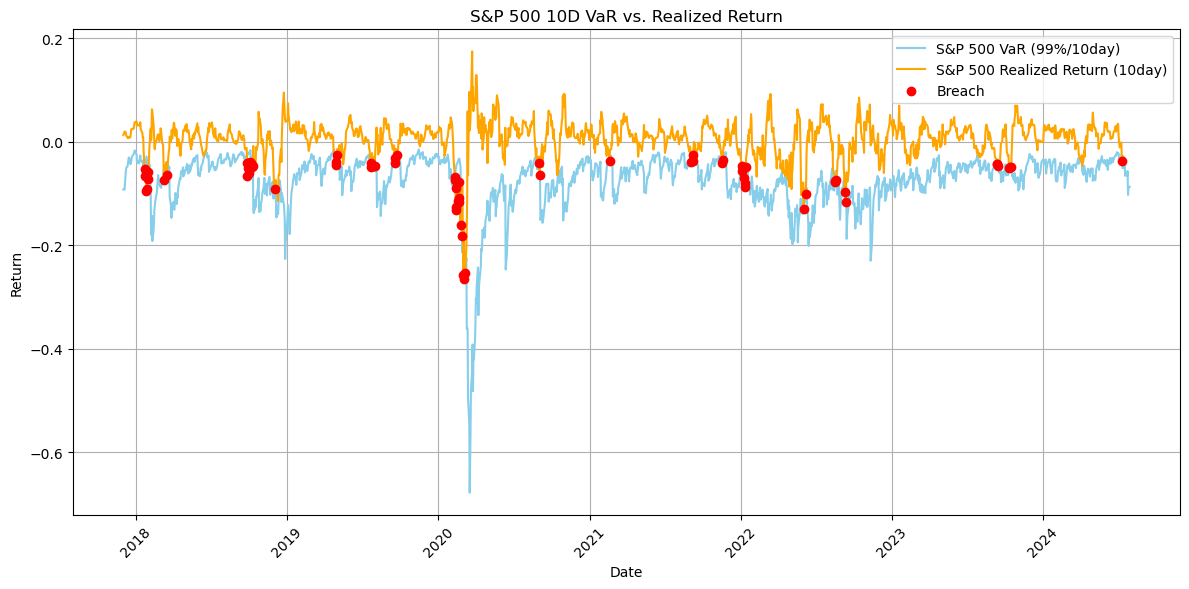

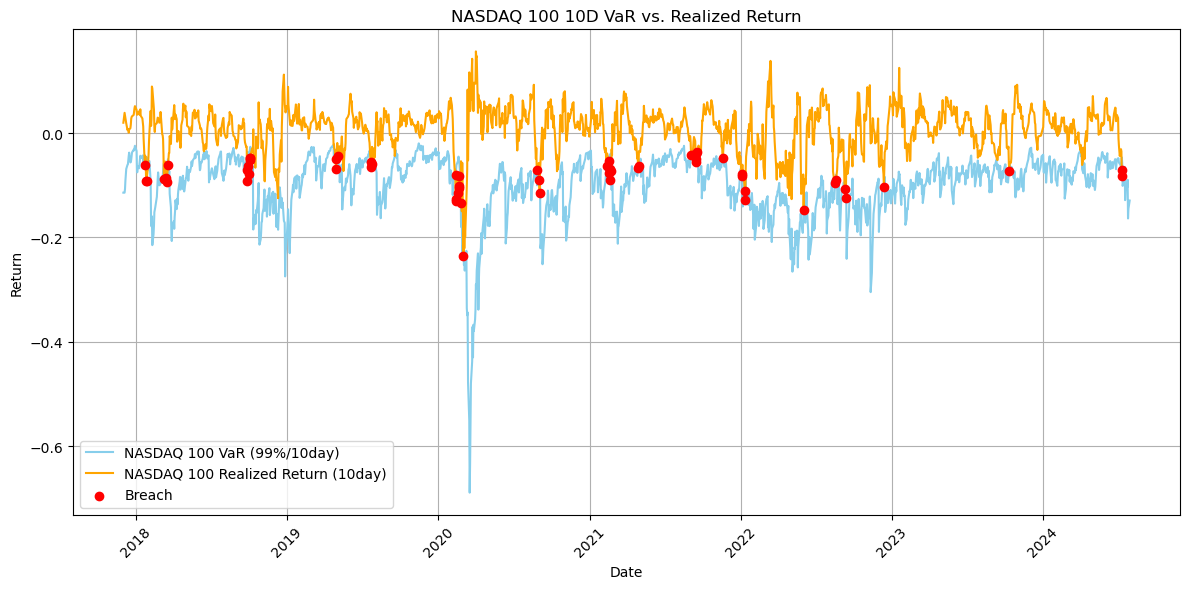

In [10]:
# Function to plot 10-day VaR vs. realized returns with breaches
def plot_var_vs_realized_return(df, name):
    plt.figure(figsize=(12, 6))
    
    # Plot VaR
    plt.plot(df['Date'], -df['VaR_10D'], label=f'{name} VaR (99%/10day)', color='skyblue')
    
    # Plot realized returns
    plt.plot(df['Date'], df['Ret_10D'], label=f'{name} Realized Return (10day)', color='orange')
    
    # Plot breaches
    breaches = df[df['Breach']]
    plt.scatter(breaches['Date'], breaches['Ret_10D'], color='red', label='Breach', zorder=5)
    
    plt.title(f"{name} 10D VaR vs. Realized Return")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for both datasets
plot_var_vs_realized_return(sp500, "S&P 500")
plot_var_vs_realized_return(nasdaq100, "NASDAQ 100")

In [4]:
# List of breaches
def list_breaches(df, name):
    breaches = df[df['Breach']][['Date', 'Closing Price', 'LogReturn', 'VaR_10D', 'Ret_10D', 'Breach']]
    print(f"{name} VaR Breaches:")
    print(breaches.to_string(index=False))
    print()

# list_breaches(sp500, "S&P 500")
# list_breaches(nasdaq100, "NASDAQ 100")


## Findings
During the COVID-19 pandemic, financial markets experienced unprecedented volatility. The S&P 500 and NASDAQ 100, two major indices, showed significant VaR (Value at Risk) breaches. This analysis explores the reasons behind these breaches and offers insights from an investment risk analyst perspective.

## S&P 500 VaR Breaches

- **Count**: 61
- **Percentage**: 3.65%

## NASDAQ 100 VaR Breaches

- **Count**: 43
- **Percentage**: 2.57%

## Analysis

### 1. Market Volatility During COVID-19

**Initial Shock**: The onset of the pandemic in early 2020 caused a massive sell-off as investors reacted to uncertainty and fear. This led to several consecutive breaches as markets recalibrated.

**Policy Responses**: Central banks globally implemented aggressive monetary policies, including rate cuts and quantitative easing, which initially contributed to market instability.

**Sector Impact**: Different sectors were impacted differently. Technology stocks, heavily represented in NASDAQ 100, benefited from the shift to remote work, helping to moderate breaches compared to the S&P 500.

### 2. Post-COVID Recovery and Adjustments

**Rapid Recovery**: After the initial shock, markets recovered quickly, driven by stimulus measures and vaccine rollouts. This recovery phase saw fewer breaches, indicating reduced volatility.

**Inflation Concerns**: As economies reopened, inflation fears emerged, causing periodic spikes in volatility and subsequent breaches.

**Supply Chain Issues**: Disruptions in global supply chains contributed to volatility, particularly impacting sectors dependent on global trade.

### 3. Differences Between S&P 500 and NASDAQ 100

**Sector Composition**: The S&P 500 is more diversified across sectors, including financials and energy, which faced more significant challenges during the pandemic. This contributed to a higher breach percentage compared to NASDAQ 100.

**Tech Resilience**: NASDAQ 100's heavy weighting in technology and healthcare provided some insulation against broader market declines, as these sectors were less impacted by lockdowns.

## Reasons for the Results

1. **Unprecedented Events**: The pandemic was a black swan event, leading to extreme market conditions not fully captured by historical data used in VaR models.

2. **Model Limitations**: VaR models assume normal market conditions and may not fully account for extreme tail risks. The breaches highlight the need for stress testing and scenario analysis beyond traditional VaR calculations.

3. **Behavioral Factors**: Investor behavior, driven by fear and uncertainty, exacerbated market movements beyond what VaR models anticipated.



## Implementation with the input of Exponentially Weighted Moving Average (EWMA) volatility instead of rolling stardard deviation.

### EWMA Variance Formula

The Exponentially Weighted Moving Average (EWMA) variance is calculated as follows:

$$
\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1 - \lambda) r_{t-1}^2
$$

Where:
- $\sigma_t^2$ is the EWMA variance at time $t$.
- $\lambda$ is the decay factor (e.g., 0.72).
- $r_{t-1}$ is the return at time $t-1$.

### Why Use EWMA Volatility in Calculating VaR

1. **Responsive to Recent Changes**: EWMA gives more weight to recent data, quickly reflecting market shifts.

2. **Smoothing Effect**: It reduces noise and outliers, providing stable volatility estimates.

3. **Mathematical Simplicity**: The recursive formula is easy to implement and computationally efficient.

4. **Better Risk Management**: Offers more accurate risk assessments by focusing on current market conditions.

5. **Industry Standard**: Widely used and accepted in financial institutions, often aligning with regulatory requirements.

In [5]:
# Function to calculate EWMA variance
def calculate_ewma_variance(returns, lambda_=0.72):
    variance = returns.var()  # Initialize with the variance of the entire dataset
    ewma_variances = [variance]

    for t in range(1, len(returns)):
        if pd.notnull(returns.iloc[t - 1]):
            variance = lambda_ * ewma_variances[-1] + (1 - lambda_) * returns.iloc[t - 1] ** 2
        else:
            variance = ewma_variances[-1]
        ewma_variances.append(variance)

    return pd.Series(ewma_variances, index=returns.index)


# Function to calculate VaR and identify breaches using EWMA
def calculate_var_and_breaches_ewma(df, factor=norm.ppf(0.99), lambda_=0.72):
    df['EWMA_Variance'] = calculate_ewma_variance(df['LogReturn'], lambda_)
    df['EWMA_Std'] = np.sqrt(df['EWMA_Variance'])
    df['VaR_10D'] = factor * df['EWMA_Std'] * np.sqrt(10)
    df['Ret_10D'] = np.log(df['Closing Price'].shift(-10) / df['Closing Price'])
    df['Breach'] = df['Ret_10D'] < -df['VaR_10D']
    return df


# Process both datasets
sp500 = calculate_log_returns(sp500)
sp500 = calculate_var_and_breaches_ewma(sp500)

nasdaq100 = calculate_log_returns(nasdaq100)
nasdaq100 = calculate_var_and_breaches_ewma(nasdaq100)

# Count and percentage of VaR breaches
def report_breaches(df, name):
    total_observations = df['Breach'].count()
    breach_count = df['Breach'].sum()
    breach_percentage = (breach_count / total_observations) * 100
    print(f"{name} VaR Breaches:")
    print(f"Count: {breach_count}")
    print(f"Percentage: {breach_percentage:.2f}%")
    print()


report_breaches(sp500, "S&P 500")
report_breaches(nasdaq100, "NASDAQ 100")

S&P 500 VaR Breaches:
Count: 74
Percentage: 4.42%

NASDAQ 100 VaR Breaches:
Count: 60
Percentage: 3.59%



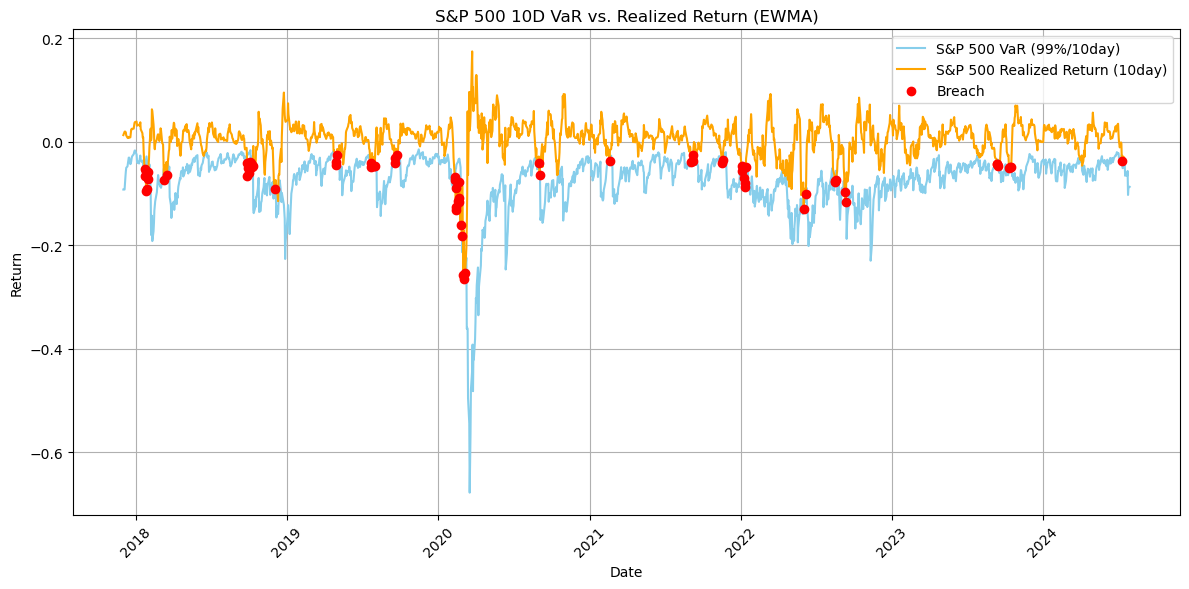

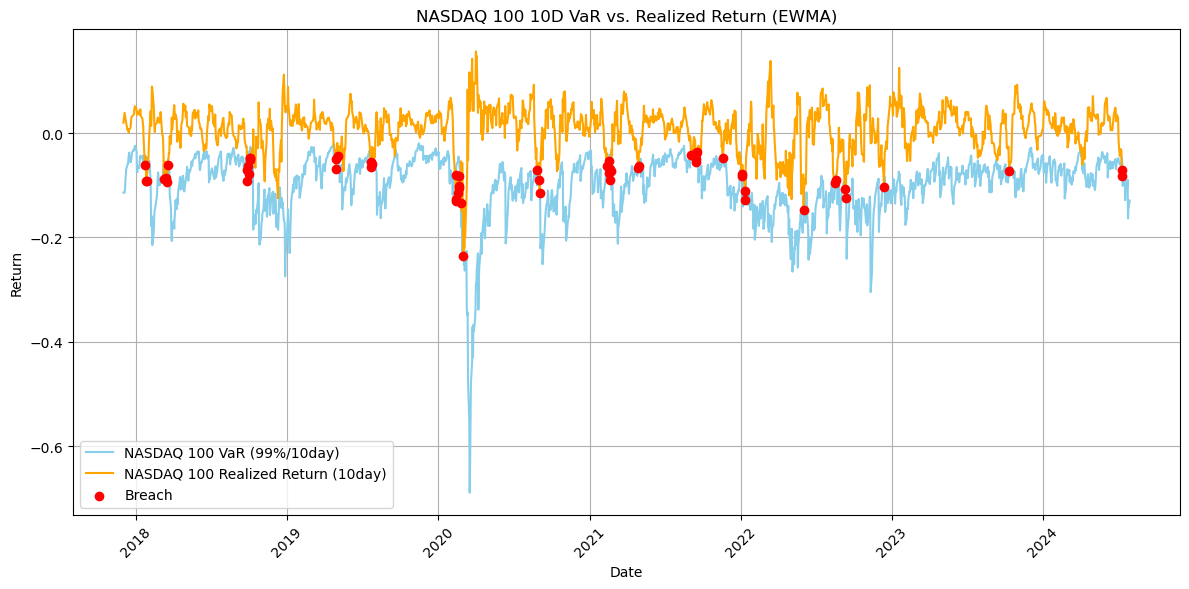

In [12]:
# Function to plot 10-day VaR vs. realized returns with breaches
def plot_var_vs_realized_return_ewma(df, name):
    plt.figure(figsize=(12, 6))
    
    # Plot VaR
    plt.plot(df['Date'], -df['VaR_10D'], label=f'{name} VaR (99%/10day)', color='skyblue')
    
    # Plot realized returns
    plt.plot(df['Date'], df['Ret_10D'], label=f'{name} Realized Return (10day)', color='orange')
    
    # Plot breaches
    breaches = df[df['Breach']]
    plt.scatter(breaches['Date'], breaches['Ret_10D'], color='red', label='Breach', zorder=5)
    
    plt.title(f"{name} 10D VaR vs. Realized Return (EWMA)")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for both datasets
plot_var_vs_realized_return_ewma(sp500, "S&P 500")
plot_var_vs_realized_return_ewma(nasdaq100, "NASDAQ 100")

In [7]:
# List of breaches
def list_breaches(df, name):
    breaches = df[df['Breach']][
        ['Date', 'Closing Price', 'LogReturn', 'VaR_10D', 'Ret_10D', 'Breach']]
    print(f"{name} VaR Breaches:")
    print(breaches.to_string(index=False))
    print()


# list_breaches(sp500, "S&P 500")
# list_breaches(nasdaq100, "NASDAQ 100")

### Analysis: Higher VaR Breaches with EWMA Volatility

### S&P 500 VaR Breaches

- **Count**: 74
- **Percentage**: 4.42%

### NASDAQ 100 VaR Breaches

- **Count**: 60
- **Percentage**: 3.59%

1. **Sensitivity to Recent Changes**:
   - **EWMA**: More responsive to recent volatility spikes.
   - **Rolling Volatility**: Averages past data, smoothing out fluctuations.

2. **Market Conditions**:
   - **Volatile Periods**: EWMA captures rapid shifts, leading to higher breaches.
   - **Calm Periods**: Rolling may underestimate sudden risks.

3. **Adaptive Nature**:
   - **EWMA**: Quickly adapts to market stress but may overestimate in stable times.
   - **Rolling**: Less responsive, delaying risk detection.

Overall, EWMA’s quick response to market changes results in more frequent VaR breaches compared to rolling volatility.



 

## The impact of λ on smoothness of EWMA-predicted volatility.

The parameter λ (lambda) in EWMA significantly influences the smoothness of predicted volatility:

A higher λ (closer to 1) results in smoother volatility estimates, as it gives more weight to historical data and responds more slowly to recent market changes. This leads to a more stable but less responsive volatility prediction.

A lower λ (closer to 0) produces more reactive and potentially jagged volatility estimates, as it places greater emphasis on recent observations. This makes the model more sensitive to short-term market fluctuations but potentially less stable over time.

Choosing an appropriate λ involves balancing the trade-off between responsiveness to new information and stability of estimates. The optimal value often depends on the specific market characteristics and the desired application of the volatility forecasts.